# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  We use VGG with batch normalization through out this notebook.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.trainer as trainer
import torch.utils.trainer.plugins
from torch.autograd import Variable
import numpy as np
import pandas as pd
import os

from torchsample.modules import ModuleTrainer
from torchsample.metrics import CategoricalAccuracy

import glob
import PIL
import matplotlib.pyplot as plt

import scipy.misc

%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/ubuntu/software/torchsample/torchsample/datasets.py:18: UserWarning: Cant import nibabel.. Cant load brain images
  warnings.warn('Cant import nibabel.. Cant load brain images')


In [2]:
def denorm(tensor):
    # Undo the image normalization + clamp between 0 and 1 to avoid image artifacts
    for t, m, s in zip(tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): 
        t.mul_(s).add_(m).clamp_(0, 1)
    return tensor

def get_images_to_plot(images_tensor):
    denormalize = transforms.Compose([
        transforms.Lambda(denorm)
    ])
    return denormalize(images_tensor)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [3]:
data_path = "data/fish/"
# data_path = "data/fish/sample/"
use_cuda = True
batch_size = 64
print('Using CUDA:', use_cuda)

Using CUDA: True


In [4]:
cuda_device = -1
if use_cuda:
    cuda_device = 0

In [5]:
# Change to True to create & populate the validation directory
if False:
    # Create validation directory
    %cd data/fish/train
    %mkdir -p ../valid
    %cd ../../../
    
    # Create a folder for each category of fish
    for d in glob.glob('*'): os.mkdir('../valid/' + d)

    # Copy some random images from each class
    shuf = np.random.permutation(glob.glob('*/*.jpg'))
    for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

# Change to True to create the sample dir      
# Manually inspect all classes have at least one fish
if False:
    %cd data/fish/train
    %mkdir -p ../sample
    %mkdir -p ../sample/train
    %mkdir -p ../sample/valid
    
    from shutil import copyfile

    # Create a folder for each category of fish
    for d in glob.glob('*'): 
        os.mkdir('../sample/train/' + d)
        os.mkdir('../sample/valid/' + d)
        
    # Copy a few samples per fish
    shuf = np.random.permutation(glob.glob('*/*.jpg'))
    for i in range(60): copyfile(shuf[i], '../sample/train/' + shuf[i])

    %cd ../valid
    shuf = np.random.permutation(glob.glob('*/*.jpg'))
    for i in range(50): copyfile(shuf[i], '../sample/valid/' + shuf[i])
    %cd ../../../

In [6]:
# This class is required so we can easily extract the labels of the training dataset
class ShuffleOnceSampler(torch.utils.data.sampler.Sampler):
    """Randomly shuffles the data source on creation, without replacement.
    Returns the same sequential order on every epoch.
    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source):
        self.shuffled_order = torch.randperm(len(data_source)).long()

    def __iter__(self):
        return iter(self.shuffled_order)

    def __len__(self):
        return len(self.shuffled_order)

In [7]:
# Data loading code
traindir = os.path.join(data_path, 'train')
valdir = os.path.join(data_path, 'valid') 
testdir = os.path.join(data_path, 'test')

# pytorch way of implementing fastai's get_batches, (utils.py)
def get_data_loader(dirname, batch_size=64, shuffle_once=False, image_size=(224, 224)):
    # pytorch's VGG requires images to be 224x224 and normalized using https://github.com/pytorch/vision#models
    normalize = transforms.Compose([
        transforms.Lambda(lambda img: img.resize(image_size, Image.BILINEAR)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ])
    
    image_folder = datasets.ImageFolder(dirname, normalize)
    sampler = None
    if shuffle_once:
        sampler = ShuffleOnceSampler(image_folder)
    return torch.utils.data.DataLoader(image_folder, batch_size=batch_size, 
                                       shuffle=False, pin_memory=use_cuda, sampler=sampler), image_folder

train_loader, train_folder = get_data_loader(traindir, batch_size=batch_size, shuffle_once=True)
val_loader, val_folder = get_data_loader(valdir, batch_size=batch_size)
test_loader, test_folder = get_data_loader(testdir, batch_size=batch_size)

print('Images in train folder:', len(train_folder.imgs))
print('Images in val folder:', len(val_folder.imgs))
print('Images in test folder:', len(test_folder.imgs))

Images in train folder: 3277
Images in val folder: 500
Images in test folder: 13153


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization. For more information about batch normalization please see this [notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [8]:
# Monkey patch the parameters() to return trainable weights only
import types

def parameters(self):
    p = filter(lambda p: p.requires_grad, nn.Module.parameters(self))
    return p

# TODO create a utiliy class that inits models correctly
# Keras inits the model with sensible defaults, PyTorch does not
def init_model(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight)
            if m.bias is not None:
                nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant(m.weight, 1)
            nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant(m.weight, 1)
            nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal(m.weight, mean=0, std=0.01)
            nn.init.constant(m.bias, 0)

In [9]:
# Load the model
model = models.vgg16_bn(pretrained=True)

# Finetune by replacing the last fully connected layer and freezing all network parameters
for param in model.parameters():
    param.requires_grad = False
model.parameters = types.MethodType(parameters, model)

# Replace the last fully-connected layer matching the new class count
classes = train_loader.dataset.classes
num_classes = len(classes)
print('Using {:d} classes: {}'.format(num_classes, classes))

model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

Using 8 classes: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [10]:
# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
# enable cuda if available
if(use_cuda):
    model.cuda()
    criterion.cuda()
    
def getTrainer(model):
    trainer = ModuleTrainer(model)
    trainer.compile(optimizer='adam', loss=criterion, metrics=[CategoricalAccuracy()])
    
    return trainer

In [11]:
trainer = getTrainer(model)

In [12]:
# TODO fix this: 'ImageFolder' object has no attribute 'num_inputs', module_trainer.py (318)
# trainer.fit_loader(train_loader, val_loader=val_loader, num_epoch=1, cuda_device=cuda_device)

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [13]:
class VggNoClassifier(nn.Module):
    def __init__(self, vgg):
        super(VggNoClassifier, self).__init__()
        # The last feature is a Max Pooling layer, remove it
        num_features = len(vgg.features._modules)
        print(num_features, type(vgg.features[num_features - 2]), type(vgg.features[num_features - 1]))
        self.features = nn.Sequential(*[vgg.features[idx] for idx in range(num_features - 1)])
        
    def forward(self, x):
        x = self.features(x)
        return x

In [14]:
vgg = VggNoClassifier(model)
if(use_cuda):
    vgg.cuda()
    
trainer = ModuleTrainer(vgg)

44 <class 'torch.nn.modules.activation.ReLU'> <class 'torch.nn.modules.pooling.MaxPool2d'>


In [15]:
if False:
    %time conv_train = trainer.predict_loader(train_loader, cuda_device=cuda_device).data # Extract Tensor from Variable
    %time conv_val = trainer.predict_loader(val_loader, cuda_device=cuda_device).data
    %time conv_test = trainer.predict_loader(test_loader, cuda_device=cuda_device).data

    labels_train = torch.cat([labels for (batch, labels) in train_loader])
    labels_val = torch.cat([labels for (batch, labels) in val_loader])

    %mkdir -p data/fish/results
    torch.save(conv_train, data_path + 'results/conv_train_224.pth')
    torch.save(conv_val,   data_path + 'results/conv_val_224.pth')
    torch.save(conv_test,  data_path + 'results/conv_test_224.pth')

    torch.save(labels_train, data_path + 'results/labels_train_224.pth')
    torch.save(labels_val,   data_path + 'results/labels_val_224.pth')
else:
    conv_train = torch.load(data_path + 'results/conv_train_224.pth')
    conv_val   = torch.load(data_path + 'results/conv_val_224.pth')
    conv_test  = torch.load(data_path + 'results/conv_test_224.pth')

    labels_train = torch.load(data_path + 'results/labels_train_224.pth')
    labels_val   = torch.load(data_path + 'results/labels_val_224.pth')

In [16]:
conv_train.size(), labels_train.size()

(torch.Size([3277, 512, 14, 14]), torch.Size([3277]))

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [17]:
class FCNet3LayerClassifer(nn.Module):
    
    def __init__(self, p):
        super(FCNet3LayerClassifer, self).__init__()
        size_after_pool = 512 * 7 * 7 # 7 = 14 / 2
        feature_size = 512
        
        self.maxPool = nn.Sequential(nn.MaxPool2d((2, 2)),
                                     nn.BatchNorm2d(feature_size),
                                     nn.Dropout2d(p / 4))
        
        self.linear = nn.Sequential(nn.Linear(size_after_pool, feature_size), 
                                    nn.ReLU(inplace=True), 
                                    nn.BatchNorm1d(feature_size), 
                                    nn.Dropout(p),
                                    
                                    nn.Linear(feature_size, feature_size), 
                                    nn.ReLU(inplace=True), 
                                    nn.BatchNorm1d(feature_size), 
                                    nn.Dropout(p / 2))
                                    
        self.classifier = nn.Linear(feature_size, num_classes)
        init_model(self)
        
    def forward(self, x):
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.classifier(x)
        return x

In [18]:
model = FCNet3LayerClassifer(0.6)
if(use_cuda):
    model.cuda()

trainer = getTrainer(model)

In [19]:
trainer.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=3, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/3: 53 batches [00:01, 32.58 batches/s, acc=73.97, loss=0.782, val_loss=0.22, val_acc=93.00]
Epoch 2/3: 53 batches [00:01, 48.93 batches/s, acc=94.42, loss=0.107, val_loss=0.102, val_acc=97.00]
Epoch 3/3: 53 batches [00:01, 49.03 batches/s, acc=98.02, loss=0.0301, val_loss=0.0787, val_acc=97.40]


In [20]:
trainer.adjust_learning_rate(1e-4)

In [21]:
trainer.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=7, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/7: 53 batches [00:01, 48.97 batches/s, acc=99.05, loss=0.021, val_loss=0.0603, val_acc=98.20]
Epoch 2/7: 53 batches [00:01, 49.08 batches/s, acc=99.45, loss=0.0142, val_loss=0.0576, val_acc=98.20]
Epoch 3/7: 53 batches [00:01, 49.05 batches/s, acc=99.63, loss=0.0288, val_loss=0.0572, val_acc=98.20]
Epoch 4/7: 53 batches [00:01, 49.05 batches/s, acc=99.48, loss=0.00367, val_loss=0.0577, val_acc=98.40]
Epoch 5/7: 53 batches [00:01, 49.01 batches/s, acc=99.63, loss=0.0112, val_loss=0.0608, val_acc=98.20]
Epoch 6/7: 53 batches [00:01, 49.08 batches/s, acc=99.63, loss=0.0636, val_loss=0.0562, val_acc=98.20]
Epoch 7/7: 53 batches [00:01, 49.03 batches/s, acc=99.79, loss=0.00629, val_loss=0.062, val_acc=98.20]


## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [22]:
filenames_train = [filename for filename, _ in train_loader.dataset.imgs]
sizes_tuples_train = [PIL.Image.open(f).size for f in filenames_train]
unique_sizes = list(set(sizes_tuples_train))
size_to_idx = {size : idx for idx, size in enumerate(unique_sizes)}
size_to_idx[(1334, 750)] = 8 # Add any other sizes not present in training set, but present in val or test sets
image_sizes_count = len(size_to_idx)

In [23]:
import collections
collections.Counter(sizes_tuples_train)

Counter({(1192, 670): 170,
         (1244, 700): 23,
         (1276, 718): 185,
         (1280, 720): 1892,
         (1280, 750): 521,
         (1280, 924): 56,
         (1280, 974): 341,
         (1334, 750): 27,
         (1518, 854): 33,
         (1732, 974): 29})

In [24]:
def one_hot_encode_normalize(list_indexes, index_size):
    hot_encoded = torch.FloatTensor(len(list_indexes), index_size).zero_()
    idx = torch.LongTensor(list_indexes).view(-1, 1)
    hot_encoded.scatter_(1, idx, 1.0)
    return hot_encoded - hot_encoded.mean() / hot_encoded.std()

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [25]:
sizes_train = one_hot_encode_normalize(list(map(size_to_idx.__getitem__, sizes_tuples_train)), image_sizes_count)
sizes_train.size()

torch.Size([3277, 10])

In [26]:
filenames_val = [filename for filename, _ in val_loader.dataset.imgs]
sizes_tuples_val = [PIL.Image.open(f).size for f in filenames_val]
sizes_val = one_hot_encode_normalize(list(map(size_to_idx.__getitem__, sizes_tuples_val)), image_sizes_count)
sizes_val.size()

torch.Size([500, 10])

In [27]:
class MultiInput3LayerFCNetClassifer(FCNet3LayerClassifer):
    def __init__(self, p):
        super(MultiInput3LayerFCNetClassifer, self).__init__(p)
        image_size_feature = image_sizes_count
        feature_size = 512 + image_size_feature
        
        self.batchnorm = nn.BatchNorm1d(image_sizes_count)
        self.classifier = nn.Linear(feature_size, num_classes)
        init_model(self)
        
    def forward(self, x, x_image_sizes):
        x_bn = self.batchnorm(x_image_sizes)
        
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        x = torch.cat([x, x_bn], dim=1)
        
        x = self.classifier(x)
        return x

In [28]:
model = MultiInput3LayerFCNetClassifer(0.6)
if(use_cuda):
    model.cuda()

trainer = getTrainer(model)

In [29]:
trainer.fit((conv_train, sizes_train), labels_train, val_data=((conv_val, sizes_val), labels_val), num_epoch=3, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/3: 53 batches [00:01, 47.66 batches/s, acc=74.92, loss=0.437, val_loss=0.244, val_acc=92.20]
Epoch 2/3: 53 batches [00:01, 47.85 batches/s, acc=95.21, loss=0.118, val_loss=0.0913, val_acc=97.00]
Epoch 3/3: 53 batches [00:01, 47.87 batches/s, acc=98.11, loss=0.0405, val_loss=0.0843, val_acc=97.80]


In [30]:
trainer.adjust_learning_rate(1e-4)

In [31]:
trainer.fit((conv_train, sizes_train), labels_train, val_data=((conv_val, sizes_val), labels_val), num_epoch=7, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/7: 53 batches [00:01, 47.65 batches/s, acc=98.87, loss=0.031, val_loss=0.0698, val_acc=98.40]
Epoch 2/7: 53 batches [00:01, 47.66 batches/s, acc=99.42, loss=0.00748, val_loss=0.0675, val_acc=98.60]
Epoch 3/7: 53 batches [00:01, 47.72 batches/s, acc=99.63, loss=0.0119, val_loss=0.0694, val_acc=98.40]
Epoch 4/7: 53 batches [00:01, 47.62 batches/s, acc=99.82, loss=0.0075, val_loss=0.0688, val_acc=98.40]
Epoch 5/7: 53 batches [00:01, 47.69 batches/s, acc=99.76, loss=0.00734, val_loss=0.066, val_acc=98.40]
Epoch 6/7: 53 batches [00:01, 47.50 batches/s, acc=99.82, loss=0.00405, val_loss=0.0635, val_acc=98.60]
Epoch 7/7: 53 batches [00:01, 47.60 batches/s, acc=99.76, loss=0.0142, val_loss=0.0724, val_acc=98.40]


The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [32]:
import json

In [33]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [34]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('data/fish/annotations/{}_labels.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [35]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

For any images that have no annotations, we'll create an empty bounding box.

In [36]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [37]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(filename, size):
    bb = bb_json.get(no_folders(filename), empty_bbox)
    
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0] * conv_y
    bb[1] = bb[1] * conv_x
    bb[2] = max(bb[2] * conv_x, 0)
    bb[3] = max(bb[3] * conv_y, 0)
    
    return torch.FloatTensor(bb)

def no_folders(filename):
    return filename.split('/')[-1]

In [38]:
bbox_train = torch.stack([convert_bb(filename, size) for filename, size in zip(filenames_train, sizes_tuples_train)])
bbox_val = torch.stack([convert_bb(filename, size) for filename, size in zip(filenames_val, sizes_tuples_val)])

Now we can check our work by drawing one of the annotations.

In [39]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = bbox_val[i]
    show(get_images_to_plot(val_loader.dataset[i][0]))
    plt.gca().add_patch(create_rect(bb))

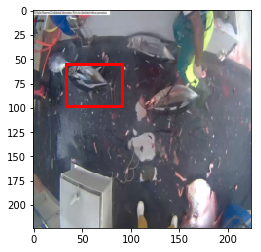

In [40]:
show_bb(0)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [41]:
class MultiOutput3LayerFCNetClassifer(FCNet3LayerClassifer):
    def __init__(self, p):
        super(MultiOutput3LayerFCNetClassifer, self).__init__(p)
        feature_size = 512
        bbox_corners_count = 4
        self.bbox_regressor = nn.Linear(feature_size, bbox_corners_count)
        init_model(self)
        
    def forward(self, x):
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        x_bb = self.bbox_regressor(x)
        x = self.classifier(x)
        return x, x_bb

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [42]:
# TODO how to pass a weight to each loss function?
model = MultiOutput3LayerFCNetClassifer(0.6) 
mse_loss = nn.MSELoss()
if(use_cuda):
    model.cuda()
    mse_loss.cuda()

trainer = getTrainer(model)
trainer.compile(optimizer='adam', loss=[criterion, mse_loss], metrics=[CategoricalAccuracy(), None], loss_weights=[1., 0.001])

In [43]:
trainer.fit(conv_train, (labels_train, bbox_train), val_data=(conv_val, (labels_val, bbox_val)), num_epoch=3, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/3: 53 batches [00:01, 46.96 batches/s, val_loss_0=0.212, val_loss=4.87, loss_1=6.66e+03, loss_0=0.707, val_acc=93.80, acc=74.24, loss=7.37, val_loss_1=4.65e+03]
Epoch 2/3: 53 batches [00:01, 47.06 batches/s, val_loss_0=0.111, val_loss=4.68, loss_1=6.62e+03, loss_0=0.0922, val_acc=96.20, acc=95.27, loss=6.71, val_loss_1=4.57e+03]
Epoch 3/3: 53 batches [00:01, 47.07 batches/s, val_loss_0=0.0966, val_loss=4.4, loss_1=6.24e+03, loss_0=0.0134, val_acc=97.40, acc=98.29, loss=6.25, val_loss_1=4.3e+03]


In [44]:
trainer.adjust_learning_rate(1e-5)

In [45]:
trainer.fit(conv_train, (labels_train, bbox_train), val_data=(conv_val, (labels_val, bbox_val)), num_epoch=10, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/10: 53 batches [00:01, 47.19 batches/s, val_loss_0=0.0828, val_loss=4.39, loss_1=6.19e+03, loss_0=0.0254, val_acc=97.80, acc=98.41, loss=6.22, val_loss_1=4.31e+03]
Epoch 2/10: 53 batches [00:01, 46.97 batches/s, val_loss_0=0.0789, val_loss=4.38, loss_1=6.11e+03, loss_0=0.0847, val_acc=97.80, acc=98.69, loss=6.19, val_loss_1=4.3e+03]
Epoch 3/10: 53 batches [00:01, 46.96 batches/s, val_loss_0=0.0759, val_loss=4.37, loss_1=6.13e+03, loss_0=0.0456, val_acc=97.80, acc=98.99, loss=6.18, val_loss_1=4.3e+03]
Epoch 4/10: 53 batches [00:01, 47.05 batches/s, val_loss_0=0.0744, val_loss=4.36, loss_1=6.21e+03, loss_0=0.0439, val_acc=97.80, acc=98.96, loss=6.25, val_loss_1=4.29e+03]
Epoch 5/10: 53 batches [00:01, 46.97 batches/s, val_loss_0=0.0714, val_loss=4.36, loss_1=6.12e+03, loss_0=0.00683, val_acc=98.00, acc=99.12, loss=6.13, val_loss_1=4.29e+03]
Epoch 6/10: 53 batches [00:01, 47.02 batches/s, val_loss_0=0.0699, val_loss=4.35, loss_1=6.1e+03, loss_0=0.0439, val_acc=98.00, acc=99.12, lo

In [46]:
# TODO This model does not seem to converge on a solution that accurately finds the bounding boxes. 
# (It tends to get stucked and always give the same or similar result)

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [47]:
predictions = trainer.predict(conv_train, batch_size=batch_size, cuda_device=cuda_device)

In [48]:
def show_bb_pred(i):
    bb = bbox_val[i]
    bb_pred = predictions[1][i].data
    plt.figure(figsize=(6,6))
    show(get_images_to_plot(val_loader.dataset[i][0]))
    ax = plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))
    
    _, class_id = predictions[0][i].max(0)
    class_id_number = torch.max(class_id.data) # From Tensor to Number
    print(classes[class_id_number])
    print(bb_pred, bb)

OTHER

 2.3119
 1.7369
 2.0757
 3.0232
[torch.FloatTensor of size 4]
 
 31.5097
 20.7147
 93.9185
 68.3231
[torch.FloatTensor of size 4]



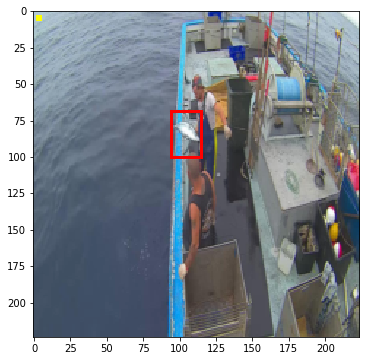

In [49]:
show_bb_pred(6)

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [50]:
train_loader, train_folder = get_data_loader(traindir, batch_size=32, shuffle_once=True, image_size=(640, 360))
val_loader, val_folder = get_data_loader(valdir, batch_size=32, image_size=(640, 360))
test_loader, test_folder = get_data_loader(testdir, batch_size=32, image_size=(640, 360))

print('Images in train folder:', len(train_folder.imgs))
print('Images in val folder:', len(val_folder.imgs))
print('Images in test folder:', len(test_folder.imgs))

Images in train folder: 3277
Images in val folder: 500
Images in test folder: 13153


The image shows that things are much clearer at this size.

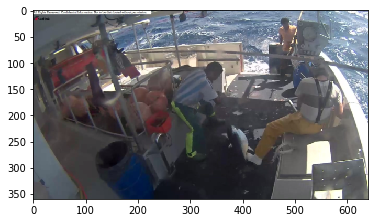

In [51]:
show(get_images_to_plot(train_loader.dataset[0][0]))

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [52]:
# Load the model
model = models.vgg16_bn(pretrained=True)
vgg = VggNoClassifier(model)
if(use_cuda):
    vgg.cuda()
    
trainer = ModuleTrainer(vgg)

44 <class 'torch.nn.modules.activation.ReLU'> <class 'torch.nn.modules.pooling.MaxPool2d'>


In [55]:
if False:
    %time conv_train = trainer.predict_loader(train_loader, cuda_device=cuda_device).data # Extract Tensor from Variable
    %time conv_val = trainer.predict_loader(val_loader, cuda_device=cuda_device).data
    %time conv_test = trainer.predict_loader(test_loader, cuda_device=cuda_device).data

    labels_train = torch.cat([labels for (batch, labels) in train_loader])
    labels_val = torch.cat([labels for (batch, labels) in val_loader])

    %mkdir -p data/fish/results
    torch.save(conv_train, data_path + 'results/conv_train_640.pth')
    torch.save(conv_val,   data_path + 'results/conv_val_640.pth')
    torch.save(conv_test,  data_path + 'results/conv_test_640.pth')

    torch.save(labels_train, data_path + 'results/labels_train_640.pth')
    torch.save(labels_val,   data_path + 'results/labels_val_640.pth')
else:
    conv_train = torch.load(data_path + 'results/conv_train_640.pth')
    conv_val   = torch.load(data_path + 'results/conv_val_640.pth')
    conv_test  = torch.load(data_path + 'results/conv_test_640.pth')

    labels_train = torch.load(data_path + 'results/labels_train_640.pth')
    labels_val   = torch.load(data_path + 'results/labels_val_640.pth')

In [56]:
conv_train.size(), labels_train.size(), conv_test.size()

(torch.Size([3277, 512, 22, 40]),
 torch.Size([3277]),
 torch.Size([13153, 512, 22, 40]))

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a lot of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [57]:
import torch.nn.functional as F

class FCNClassifer(nn.Module):
    
    def __init__(self, p):
        super(FCNClassifer, self).__init__()
        feature_size = 512
        feature_size_conv = 128
        kernel_size = (3, 3)
        padding = (1, 1)
        
        self.fcn = nn.Sequential(nn.BatchNorm2d(feature_size),
                                 nn.Conv2d(feature_size, feature_size_conv, kernel_size, padding=padding),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm2d(feature_size_conv),
                                 nn.MaxPool2d((2, 2)),
                                 
                                 nn.Conv2d(feature_size_conv, feature_size_conv, kernel_size, padding=padding),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm2d(feature_size_conv),
                                 nn.MaxPool2d((2, 2)),

                                 nn.Conv2d(feature_size_conv, feature_size_conv, kernel_size, padding=padding),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm2d(feature_size_conv),
                                 nn.MaxPool2d((1, 2)),
                                 
                                 nn.Conv2d(feature_size_conv, num_classes, kernel_size, padding=padding),
                                 )
        self.dropout = nn.Dropout2d(p)
        init_model(self)
        
    def forward(self, x):
        x = self.fcn(x)
        x = self.dropout(x)
        h_x_w = x.size()[2:] # h x w = 5x5
        x = F.avg_pool2d(x, kernel_size=h_x_w)
        x = x.view(-1, num_classes)
        return x

I'm not using any dropout, since I found I got better results without it.

In [117]:
model_fc = FCNClassifer(0.0)
if(use_cuda):
    model_fc.cuda()
trainer_fc = getTrainer(model_fc)

In [118]:
trainer_fc.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=3, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/3: 53 batches [00:09,  3.65 batches/s, acc=76.87, loss=0.85, val_loss=0.293, val_acc=87.00]
Epoch 2/3: 53 batches [00:09,  3.61 batches/s, acc=96.16, loss=0.0695, val_loss=0.178, val_acc=92.60]
Epoch 3/3: 53 batches [00:09,  3.61 batches/s, acc=99.27, loss=0.00418, val_loss=0.122, val_acc=95.60]


In [119]:
trainer_fc.adjust_learning_rate(1e-5)

In [120]:
trainer_fc.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=4, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/4: 53 batches [00:09,  3.61 batches/s, acc=99.85, loss=0.00361, val_loss=0.0948, val_acc=97.00]
Epoch 2/4: 53 batches [00:09,  3.60 batches/s, acc=99.91, loss=0.00338, val_loss=0.0937, val_acc=97.20]
Epoch 3/4: 53 batches [00:09,  3.59 batches/s, acc=99.91, loss=0.00322, val_loss=0.0929, val_acc=97.40]
Epoch 4/4: 53 batches [00:09,  3.61 batches/s, acc=99.94, loss=0.00311, val_loss=0.0921, val_acc=97.40]


Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [62]:
def get_convolution_image(model, image_index, channel):
    image = Variable(conv_val[image_index], volatile=True)
    x = image.unsqueeze(0) # Add the extra dimension
    if(use_cuda):
        x = x.cuda()
    print(x.size())
    conv = model.fcn(x)
    print(conv.size())
    # Get first result of batch, then grab one of the filters out of the 8 prediction ones
    print('Predicted class:', torch.max(model.forward(x), 1)[1])
    conv = conv.data[0][channel].cpu().numpy()
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

Class = 0


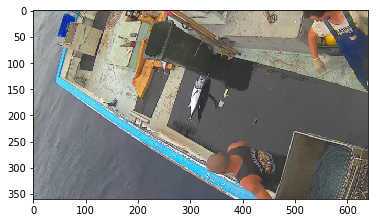

In [63]:
image_index = 88
predicted_class = val_loader.dataset[image_index][1]
print('Class =', predicted_class)
show(get_images_to_plot(val_loader.dataset[image_index][0]))

The heatmap shows that (at very low resolution) the model is finding the fish!

torch.Size([1, 512, 22, 40])
torch.Size([1, 8, 5, 5])
Predicted class: Variable containing:
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]



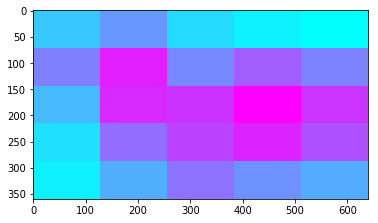

In [64]:
plt.imshow(get_convolution_image(model_fc, image_index, channel=predicted_class), cmap='cool')

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [65]:
import torch.nn.functional as F

class FCNClassiferNoMaxPooling(nn.Module):
    
    def __init__(self, p):
        super(FCNClassiferNoMaxPooling, self).__init__()
        self.fcn_module = FCNClassifer(p)
        self.fcn_module.fcn = nn.Sequential(* list(filter(lambda module: not isinstance(module, nn.MaxPool2d), self.fcn_module.fcn)))
        init_model(self)
    
    def forward(self, x):
        return self.fcn_module.forward(x)

In [102]:
model_heatmap = FCNClassiferNoMaxPooling(0)
if(use_cuda):
    model_heatmap.cuda()
trainer_heatmap = getTrainer(model_heatmap)

In [103]:
trainer_heatmap.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=2, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/2: 53 batches [00:12,  2.61 batches/s, acc=70.34, loss=1.05, val_loss=0.43, val_acc=84.80]
Epoch 2/2: 53 batches [00:12,  2.61 batches/s, acc=91.18, loss=0.254, val_loss=0.329, val_acc=86.80]


In [104]:
trainer_heatmap.adjust_learning_rate(1e-5)

In [105]:
trainer_heatmap.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=6, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/6: 53 batches [00:12,  2.59 batches/s, acc=95.36, loss=0.0829, val_loss=0.218, val_acc=92.40]
Epoch 2/6: 53 batches [00:12,  2.62 batches/s, acc=97.19, loss=0.0784, val_loss=0.19, val_acc=94.00]
Epoch 3/6: 53 batches [00:12,  2.59 batches/s, acc=97.68, loss=0.0736, val_loss=0.177, val_acc=94.20]
Epoch 4/6: 53 batches [00:12,  2.61 batches/s, acc=98.02, loss=0.0693, val_loss=0.169, val_acc=94.20]
Epoch 5/6: 53 batches [00:12,  2.60 batches/s, acc=98.14, loss=0.0654, val_loss=0.163, val_acc=94.40]
Epoch 6/6: 53 batches [00:12,  2.60 batches/s, acc=98.23, loss=0.0619, val_loss=0.157, val_acc=94.60]


#### Create heatmap

Class = 0


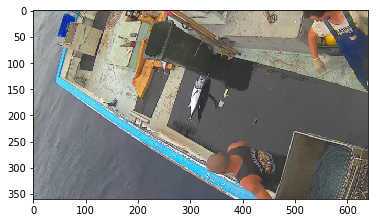

In [70]:
image_index = 88
predicted_class = val_loader.dataset[image_index][1]
print('Class =', predicted_class)
show(get_images_to_plot(val_loader.dataset[image_index][0]))

torch.Size([1, 512, 22, 40])
torch.Size([1, 8, 22, 40])
Predicted class: Variable containing:
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]



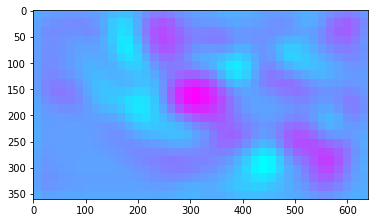

In [71]:
convolution_map = get_convolution_image(model_heatmap.fcn_module, image_index, channel=predicted_class)
plt.imshow(convolution_map, cmap='cool')

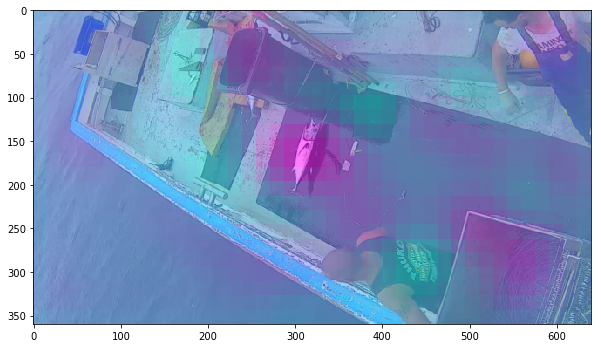

In [72]:
plt.figure(figsize=(10,10))
show(get_images_to_plot(val_loader.dataset[image_index][0]))
plt.imshow(convolution_map, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [73]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [74]:
class InceptionBlock(nn.Module):
    
    def __init__(self, in_channels, **kwargs):
        super(InceptionBlock, self).__init__()
        self.conv2d = BasicConv2d(in_channels, 16, kernel_size=1)
        self.branch1x1 = BasicConv2d(in_channels, 32, kernel_size=1, stride=2)
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, 24, kernel_size=1),
            BasicConv2d(24, 32, kernel_size=5, stride=2, padding=2))
        self.branch3x3dbl = nn.Sequential(
            BasicConv2d(in_channels, 31, kernel_size=1),
            BasicConv2d(31, 48, kernel_size=3),
            BasicConv2d(48, 48, kernel_size=3, stride=2, padding=2))

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch5x5 = self.branch5x5(x)
        branch3x3dbl = self.branch3x3dbl(x)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=2, padding=1)
        branch_pool = self.conv2d(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        # print(list(map(lambda x: x.size(), outputs)))
        return torch.cat(outputs, 1)

In [75]:
class InceptionModule(nn.Module):
    
    def __init__(self, p, **kwargs):
        super(InceptionModule, self).__init__()
        in_channels = 512
        in_channels_inception = 128
        self.batchnorm = nn.BatchNorm2d(in_channels)
        self.inception = nn.Sequential(
            InceptionBlock(in_channels),
            InceptionBlock(in_channels_inception),
            InceptionBlock(in_channels_inception))
        self.dropout = nn.Dropout(p)
        self.classifier = nn.Conv2d(in_channels_inception, num_classes, (3, 3), padding=(1, 1))
        

    def forward(self, x):
        x = self.batchnorm(x)
        x = self.inception(x)
        x = self.dropout(x)
        x = self.classifier(x)
        h_x_w = x.size()[2:] # h x w = 5x5
        x = F.avg_pool2d(x, kernel_size=h_x_w)
        x = x.view(-1, num_classes)
        return x

In [76]:
model_inception = InceptionModule(0.08)
if(use_cuda):
    model_inception.cuda()
trainer_inception = getTrainer(model_inception)

In [77]:
trainer_inception.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=2, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/2: 53 batches [00:05,  6.32 batches/s, acc=57.37, loss=1.85, val_loss=0.825, val_acc=63.80]
Epoch 2/2: 53 batches [00:05,  6.31 batches/s, acc=82.00, loss=0.735, val_loss=0.446, val_acc=84.60]


In [78]:
trainer_inception.adjust_learning_rate(1e-5)

In [79]:
trainer_inception.fit(conv_train, labels_train, val_data=(conv_val, labels_val), num_epoch=6, batch_size=batch_size, cuda_device=cuda_device)

Epoch 1/6: 53 batches [00:05,  6.27 batches/s, acc=94.90, loss=0.567, val_loss=0.361, val_acc=89.40]
Epoch 2/6: 53 batches [00:05,  6.32 batches/s, acc=95.06, loss=0.548, val_loss=0.351, val_acc=89.60]
Epoch 3/6: 53 batches [00:05,  6.32 batches/s, acc=95.24, loss=0.554, val_loss=0.344, val_acc=90.00]
Epoch 4/6: 53 batches [00:05,  6.33 batches/s, acc=95.42, loss=0.535, val_loss=0.338, val_acc=89.80]
Epoch 5/6: 53 batches [00:05,  6.32 batches/s, acc=95.45, loss=0.518, val_loss=0.332, val_acc=90.00]
Epoch 6/6: 53 batches [00:05,  6.27 batches/s, acc=95.73, loss=0.521, val_loss=0.327, val_acc=90.20]


## Pseudo-labeling

In [128]:
kaggle_trainer = trainer_fc

In [136]:
conv_val_test = torch.cat([conv_val, conv_test[:2000]]) # The 13K Test samples don't fit in ram :(
predictions_val_test_float = kaggle_trainer.predict(conv_val_test, batch_size=batch_size, cuda_device=cuda_device)
_, predictions_val_test = torch.max(predictions_val_test_float.data, 1)
predictions_val_test = predictions_val_test.view(-1)

In [139]:
conv_train_val_test = torch.cat([conv_train, conv_val_test])
labels_train_val_test = torch.cat([labels_train, predictions_val_test])
print(conv_train_val_test.size(), labels_train_val_test.size())

# Need to create a Dataset and DataLoader as using kaggle_trainer.fit() runs out of memory
train = torch.utils.data.TensorDataset(conv_train_val_test, labels_train_val_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

val = torch.utils.data.TensorDataset(conv_val, labels_val)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

torch.Size([5777, 512, 22, 40]) torch.Size([5777])


In [146]:
kaggle_trainer.fit_loader(train_loader, val_loader=val_loader, num_epoch=8, cuda_device=cuda_device)

Epoch 1/8: 92 batches [00:19,  2.53 batches/s, acc=99.07, loss=0.0806, val_loss=0.0958, val_acc=97.40]
Epoch 2/8: 92 batches [00:18,  2.54 batches/s, acc=99.12, loss=0.179, val_loss=0.0969, val_acc=97.40]
Epoch 3/8: 92 batches [00:19,  2.54 batches/s, acc=99.41, loss=0.0161, val_loss=0.0958, val_acc=97.40]
Epoch 4/8: 92 batches [00:19,  2.52 batches/s, acc=99.43, loss=0.0726, val_loss=0.0986, val_acc=97.40]
Epoch 5/8: 92 batches [00:19,  2.50 batches/s, acc=99.48, loss=0.235, val_loss=0.102, val_acc=97.40]
Epoch 6/8: 92 batches [00:19,  2.49 batches/s, acc=99.79, loss=0.0747, val_loss=0.101, val_acc=97.40]
Epoch 7/8: 92 batches [00:19,  2.49 batches/s, acc=99.71, loss=0.016, val_loss=0.103, val_acc=97.40]
Epoch 8/8: 92 batches [00:19,  2.55 batches/s, acc=99.81, loss=0.0845, val_loss=0.107, val_acc=97.40]


## Submit

In [161]:
predictions_kaggle = kaggle_trainer.predict(conv_test, batch_size=batch_size, cuda_device=cuda_device)
predictions_kaggle = F.softmax(predictions_kaggle).data
len(predictions_kaggle)

13153

In [162]:
def get_csv_filename(filename):
    file = filename.split('/')[-1]
    if 'test_stg2' in filename:
        return 'test_stg2/' + file
    else:
        return file
filenames_test = [ get_csv_filename(filename) for filename, _ in test_loader.dataset.imgs]
print(len(filenames_test))
classes

13153


['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [175]:
max_value = 0.85
min_value = (1. - max_value) / 8.
predictions_csv = torch.clamp(predictions_kaggle, min_value, max_value).numpy()

In [176]:
submission = pd.DataFrame(predictions_csv, columns=classes)
submission.insert(0, 'image', filenames_test)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_07270.jpg,0.026125,0.01875,0.01875,0.01875,0.850000,0.01875,0.01875,0.018750
1,img_00599.jpg,0.850000,0.01875,0.01875,0.01875,0.018750,0.01875,0.01875,0.030623
2,img_05572.jpg,0.850000,0.01875,0.01875,0.01875,0.018750,0.01875,0.01875,0.018750
3,img_00724.jpg,0.850000,0.01875,0.01875,0.01875,0.047665,0.01875,0.01875,0.027592
4,img_02367.jpg,0.850000,0.01875,0.01875,0.01875,0.018750,0.01875,0.01875,0.018750


In [177]:
submission_name = data_path + 'results/submission_fc.gz'
submission.to_csv(submission_name, index=False, compression='gzip')

In [178]:
from IPython.display import FileLink
FileLink(submission_name)

/home/ubuntu/kaggle/fish/data/fish/results/submission_fc.gz

This model would have ranked 350 on the private leaderboard (~231 on the public leaderboard) with public score 1.12329, private score 2.60793